In [ ]:
!pip install progress
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from progress.bar import Bar 
from IPython.display import HTML, display
from sklearn.utils import shuffle

In [ ]:
def progress(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 75%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))

In [ ]:
np.zeros((2,1,3))

array([[[0., 0., 0.]],

       [[0., 0., 0.]]])

In [ ]:
class Decompose():
    def __init__(self, nUsers, nItems, nFeatures):
        self.nUsers = nUsers
        self.nItems = nItems
        self.nFeatures = nFeatures
        self.user_feature = np.random.rand(nUsers, nFeatures)
        self.item_feature = np.random.rand(nItems, nFeatures)
        self.etta = 0.20
        self.alpha = 0.9
        # print(self.user_feature, self.item_feature)
        # print(self.user_feature, self.item_feature)

    @staticmethod
    def identity(s, deriv=False):
        if deriv:
            out = np.random.randint(low=1, high=2, size=s.shape)
            return out
        return s

    '''
        Demo Train Data
        userid, itemid, rating
           0       0      4
           0       1      3
           0       2      3.6
           1       0      2.8
    '''
    def start_train(self, userid, itemid, rating):
        V = self.user_feature[userid].reshape((1,self.nFeatures))
        W = self.item_feature[itemid].reshape((1,self.nFeatures)).T
    
        # n = 100
        prev_err = 9999999.0
        error = 0
        while True:
            # print(userid, itemid)
            in_Hidden = np.dot([[1]], V)
            out_Hidden = self.identity(in_Hidden) 
            in_OutL = np.dot(out_Hidden, W) 
            out_Out = self.identity(in_OutL)

            outputErr = rating - out_Out
            if abs(outputErr) < 0.05 or abs(outputErr) >= prev_err:
                break

            outputDelta = np.dot(outputErr ,self.identity(out_Out, deriv=True))
            
            y = np.dot(outputDelta.T, out_Hidden)
            Err_Hidden = outputDelta.dot(W.T) 

            Hidden_Delta = Err_Hidden * self.identity(out_Hidden, deriv=True)
            
            x = np.dot(Hidden_Delta.T, [[1]]) 

            V += self.etta*x.T
            W += self.etta*y.T 
            prev_err = outputErr

        self.user_feature[userid] = V
        self.item_feature[itemid] = W.T
        # print(abs(rating - np.dot(V,W)[0][0]))
        # return abs(rating - np.dot(V,W)[0][0])

    def load_weight(self, userF, itemF):
        if userF.shape==(self.nUsers, self.nFeatures) and itemF.shape==(self.nItems, self.nFeatures):
            self.user_feature, self.item_feature = userF, itemF
        else:
            print("Weights are not in proper shape")

    def train(self, train_data, test_data, epoch=5):
        train_data.columns = ['userid','itemid','rating']
        row_count,col = train_data.shape
        rows = np.arange(row_count)
        self.measures_on_train_data = []
        self.measures_on_test_data = []

        for i in range(epoch):
            # error = []
            rows = shuffle(rows)
            print("Running Epoch ", i+1)
            out = display(progress(0, 100), display_id=True)
            count=0
            for row_index in rows:
                row = train_data.loc[row_index]
                userid, itemid, rating = row['userid'],row['itemid'],row['rating']
                self.start_train(int(userid), int(itemid), rating)
                count+=1
                out.update(progress(count*100/row_count,100))
            # print("Mean Absolute error : {}".format(np.mean(error)))
            
            self.measures_on_train_data.append(self.validate(train_data))
            self.measures_on_test_data.append(self.validate(test_data))
            self.etta *= 0.8
        self.plottings(epoch)

    def plottings(self, epoch):
        msc_train = [ i[0] for i in self.measures_on_train_data]
        acc_train = [ i[1] for i in self.measures_on_train_data]

        msc_test = [ i[0] for i in self.measures_on_test_data]
        acc_test = [ i[1] for i in self.measures_on_test_data]

        plt.figure(1)
        plt.subplot(2,1,1)
        plt.plot(range(epoch), acc_train, "r--")
        plt.subplot(2,1,2)
        plt.bar(range(epoch), msc_train)

        plt.figure(2)
        plt.subplot(2,1,1)
        plt.plot(range(epoch), acc_test, "r--")
        plt.subplot(2,1,2)
        plt.bar(range(epoch), msc_test)

    
    def predict(self, userid, itemid):
        return np.dot(self.user_feature[userid].reshape((1,self.nFeatures)), self.item_feature[itemid].reshape((1,self.nFeatures)).T)[0][0]

    def validate(self, test_data, threshold=0.5):
        error = []
        test_data.columns = ['userid', 'itemid', 'rating']
        rows = len(test_data)
        count=0
        print("Running validation...")
        # out = display(progress(0, 100), display_id=True)
        for rowIndex in range(rows):
            row = test_data.loc[rowIndex]
            userid, itemid, rating = int(row['userid']), int(row['itemid']), row['rating']
            predict = self.predict(userid, itemid)
            err = abs(predict - rating)
            if err <= threshold:
                count+=1
            error.append(err)
            # out.update(progress(rowIndex*100/rows,100))



        mse = np.mean(np.square(error))
        # print(" Max Error: {0}  Min {1}".format(np.max(error), np.min(error)))
        print("MSE on test data => {}".format(np.round(mse,2)))
        print("Accuracy {}%".format(np.round(count*100/rows,2)))
        return (mse, np.round(count*100/rows,2) )

In [ ]:
# user = {'i':1, 'j':2, 'k':3}
# i,j,k = user['i'],user['j'],user['k']
# print(i,j,k)
a=np.arange(10)
shuffle(a)

array([0, 7, 3, 9, 2, 5, 8, 6, 4, 1])

In [ ]:
data = [[0,0,4],[0,2,4],[1,0,2],[1,1,3]]
train_data = pd.DataFrame(data, columns=['userid','itemid','rating'])
test_data = pd.DataFrame([[0,1,3],[1,2,2]], columns=['userid','itemid','rating'])
print(train_data.head())
print(test_data.head())

   userid  itemid  rating
0       0       0       4
1       0       2       4
2       1       0       2
3       1       1       3
   userid  itemid  rating
0       0       1       3
1       1       2       2


Running Epoch  1


Running validation...
MSE on test data => 0.66
Accuracy 50.0%
Running validation...
MSE on test data => 0.34
Accuracy 0.0%
Running Epoch  2


Running validation...
MSE on test data => 0.21
Accuracy 50.0%
Running validation...
MSE on test data => 0.08
Accuracy 100.0%
Running Epoch  3


Running validation...
MSE on test data => 0.11
Accuracy 75.0%
Running validation...
MSE on test data => 0.55
Accuracy 50.0%
Running Epoch  4


Running validation...
MSE on test data => 0.06
Accuracy 100.0%
Running validation...
MSE on test data => 0.5
Accuracy 50.0%
Running Epoch  5


Running validation...
MSE on test data => 0.04
Accuracy 100.0%
Running validation...
MSE on test data => 0.59
Accuracy 50.0%


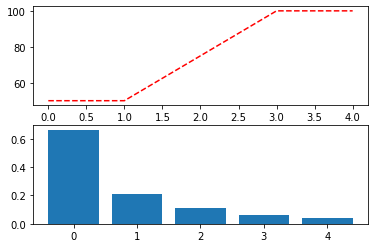

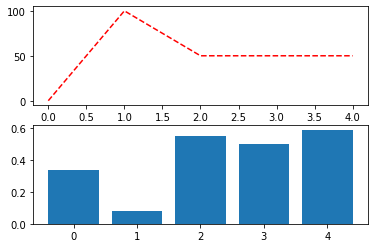

In [ ]:
model = Decompose(2,3,3)

model.train(train_data,test_data,epoch=5)

In [ ]:
train_data.loc[1]

userid    0
itemid    1
rating    3
Name: 1, dtype: int64

In [ ]:
s = np.array([1,2,3])
s.reshape((1,3))

In [ ]:
model.start_train(0,0,4)
np.dot(model.user_feature[0],model.item_feature[0].T)

3.9950500474730903

In [ ]:
model.start_train(0,1,1)
np.dot(model.user_feature[0], model.item_feature[1].T)

Output [[1.02409636]] Error [[-0.02409636]]


1.0240963551568087

In [ ]:
# np.dot(model.user_feature, model.item_feature.T)
model.predict(1,0)

2.37724925993905

In [ ]:
e = [1,2,3,4]
np.max(e)

4

### Working with real database starts here

In [ ]:
root_path = "/content/drive/My Drive/FinalYearProj-2020"

In [ ]:
data = pd.read_csv(root_path + '/DataSets/Movielens/ratings.csv')
del data["timestamp"]
data.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


In [ ]:
userId = data.userId.unique()
movieId = data.movieId.unique()
print(len(userId), len(movieId))
# print(movieId)
userId_map = { o:i for i,o in enumerate(userId) }
movieId_map = { o:i for i,o in enumerate(movieId) }

data.userId = data.userId.apply(lambda x: userId_map[x])
data.movieId = data.movieId.apply(lambda x: movieId_map[x])
# print(data.userId.apply(lambda x: userId_map[x]))
# print(data.movieId.apply(lambda x: movieId_map[x]))

data.head()
# print(len(movieId))

# print(movieId_map)

610 9724


,userId,movieId,rating
0,0,0,4.0
1,0,1,4.0
2,0,2,4.0
3,0,3,5.0
4,0,4,5.0


##### Dividing dataset into Train and Test

##### Deviding train and testset

In [ ]:
np.random.seed = 42
msk = np.random.rand(len(data)) < 0.8
train_data = data[msk].reset_index(drop=True)
test_data = data[~msk].reset_index(drop=True)

print(train_data.shape, test_data.shape)
# print(train_data.head())
# print(test_data.head())


(80549, 3) (20287, 3)


Running Epoch  1


Running validation...
MSE on test data => 1.32
Accuracy 35.48%
Running validation...
MSE on test data => 1.44
Accuracy 33.68%
Running Epoch  2


Running validation...
MSE on test data => 0.98
Accuracy 41.84%
Running validation...
MSE on test data => 1.24
Accuracy 36.58%
Running Epoch  3


Running validation...
MSE on test data => 0.81
Accuracy 44.79%
Running validation...
MSE on test data => 1.2
Accuracy 36.74%
Running Epoch  4


Running validation...
MSE on test data => 0.63
Accuracy 50.31%
Running validation...
MSE on test data => 1.14
Accuracy 37.98%
Running Epoch  5


Running validation...
MSE on test data => 0.5
Accuracy 56.1%
Running validation...
MSE on test data => 1.09
Accuracy 39.78%
Running Epoch  6


Running validation...
MSE on test data => 0.4
Accuracy 61.32%
Running validation...
MSE on test data => 1.05
Accuracy 40.68%
Running Epoch  7


Running validation...
MSE on test data => 0.37
Accuracy 63.59%
Running validation...
MSE on test data => 1.08
Accuracy 40.12%
Running Epoch  8


Running validation...
MSE on test data => 0.33
Accuracy 66.77%
Running validation...
MSE on test data => 1.06
Accuracy 41.1%
Running Epoch  9


Running validation...
MSE on test data => 0.33
Accuracy 67.78%
Running validation...
MSE on test data => 1.08
Accuracy 40.75%
Running Epoch  10


Running validation...
MSE on test data => 0.3
Accuracy 70.22%
Running validation...
MSE on test data => 1.09
Accuracy 40.78%
Running Epoch  11


Running validation...
MSE on test data => 0.31
Accuracy 70.25%
Running validation...
MSE on test data => 1.1
Accuracy 40.33%
Running Epoch  12


Running validation...
MSE on test data => 0.32
Accuracy 70.34%
Running validation...
MSE on test data => 1.13
Accuracy 40.01%
Running Epoch  13


Running validation...
MSE on test data => 0.32
Accuracy 70.79%
Running validation...
MSE on test data => 1.15
Accuracy 39.61%
Running Epoch  14


Running validation...
MSE on test data => 0.33
Accuracy 71.08%
Running validation...
MSE on test data => 1.15
Accuracy 39.58%
Running Epoch  15


Running validation...
MSE on test data => 0.34
Accuracy 70.79%
Running validation...
MSE on test data => 1.17
Accuracy 38.84%
Process finished 3794.447767972946


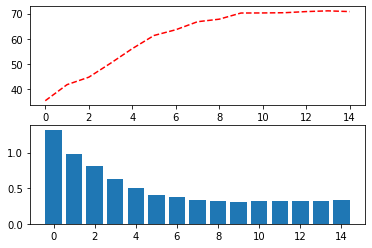

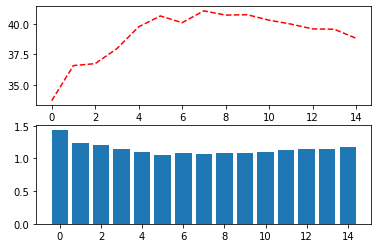

In [ ]:
import time
model = Decompose(610,9724,15)
start = time.time()
model.train(train_data, test_data, epoch=15)
print("Process finished {}".format(time.time()-start))

In [ ]:
pd.DataFrame(model.user_feature).to_csv(root_path + '/csvFiles/user_feature.csv')
pd.DataFrame(model.item_feature).to_csv(root_path + '/csvFiles/item_feature.csv')

In [ ]:
np.savetxt( root_path + '/DataSets/Movielens/measure_train.txt',model.measures_on_train_data, delimiter=",")
np.savetxt(root_path + '/DataSets/Movielens/measure_test.txt', model.measures_on_test_data,  delimiter=",")

In [ ]:
model.validate(test_data,0.5)

Running validation...
MSE on test data => 1.17
Accuracy 38.84%


(1.1683793916703067, 38.84)

In [ ]:
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import svds
import pandas as pd
import numpy as np


a = [
     [1,3,1,4,5],
     [3,5,3.5,4,6],
     [3,2,0,5,6],
     [1,2,1.5,4,5]
]

data = csc_matrix(a,dtype="float64")
mat = data
user_m = np.mean(mat, axis=1)
mat_norm = data - user_m.reshape((-1,1))

u,sig,v = svds(data,2)

# print(u)
# print(sig)
# print(v.T)

print(np.dot(np.dot(u,np.diag(sig)),v) + user_m.reshape((-1,1)))

In [ ]:
# bar = Bar("Load", max=10)
# for i in range(10):
#     bar.next()
# bar.finish()
from IPython.display import HTML, display
import time
def progress(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 75%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))


out = display(progress(0, 100), display_id=True)
for ii in range(101):
    time.sleep(0.02)
    out.update(progress(ii, 100))

In [ ]:
# from sklearn.utils import shuffle
# d = pd.DataFrame([[1,2,3],[2,3,4],[3,4,5]], columns=['a','b','c'])
# print(d.head())
# s_d = shuffle(d)
# print(s_d.head())

s = 1
s *= 0.8
print(s)


<BarContainer object of 5 artists>

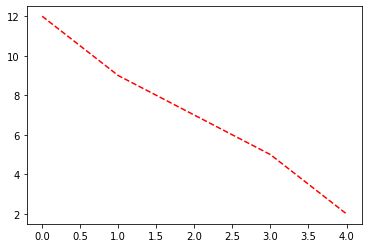

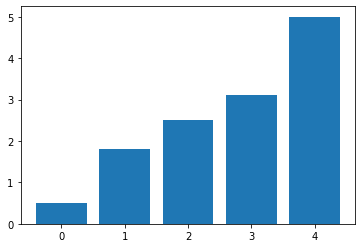

In [ ]:
s = [12,9,7,5,2]
a = [0.5,1.8,2.5,3.1,5.0]

plt.figure(1)
plt.plot(range(5), s, "r--")
plt.figure(2)
plt.bar(range(5), a)

<BarContainer object of 15 artists>

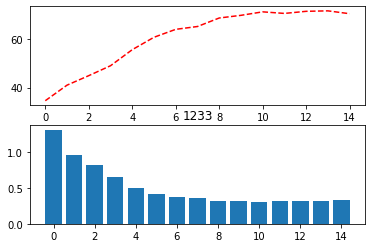

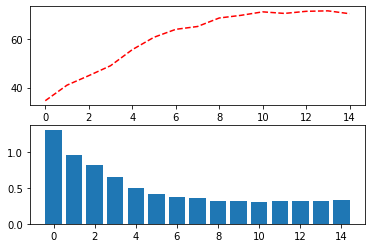

In [ ]:
# details = model.details
msc = [ i[0] for i in details]
acc = [ i[1] for i in details]

plt.figure(1)
plt.subplot(2,1,1)
plt.plot(range(15), acc, "r--")
plt.subplot(2,1,2)
plt.bar(range(15), msc)
plt.title("1233")
plt.figure(2)
plt.subplot(2,1,1)
plt.plot(range(15), acc, "r--")
plt.subplot(2,1,2)
plt.bar(range(15), msc)

In [ ]:
import cupy as np
# import numpy as np
import cuDa as pd
import time

ModuleNotFoundError: ignored

In [ ]:
start = time.time()
s = np.dot( np.random.rand(10000,10000), np.random.rand(10000,10000))
print(time.time() - start)

11.016724348068237
